In [22]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.tensorboard import SummaryWriter
import warnings
import torchvision
warnings.filterwarnings('ignore')

In [23]:
# !rm -rf runs

In [24]:
# from google.colab import drive
# drive.mount('/content/drive')

In [25]:
DEVICE = 'cuda'

In [26]:
# Pytorch categorical repar as discussed 
def reparameterise_logit(logits):
    y = nn.functional.gumbel_softmax(logits, tau=0.5, hard=False)
    return y

In [27]:
# Defining model
class M2SupervisedCNN(nn.Module):
    
    def __init__(self, 
                 num_labels,
                 input_dim, 
                 hidden_dim, 
                 output_dim,
                 latent_dim
                ):

        super(M2SupervisedCNN, self).__init__()
        
        # Encode Layers
        
        # Adding couple of CNN layer and collapising it to linear to learn RGB data

        self.enc_CNN_1 = nn.Conv2d(3, 6, 4)
        self.enc_CNN_2 = nn.Conv2d(6, 2, 2)

        output_dim = 2*28*28

        self.enc_FC_input = nn.Linear(output_dim, hidden_dim)
        
        # self.enc_FC_input = nn.Linear(input_dim, hidden_dim)

        self.ReLU = nn.ReLU()
        
        # Logits
        self.enc_fc_logits = nn.Linear(hidden_dim, num_labels)
         
        # Mean and Variance
        self.enc_FC_mean = nn.Linear(hidden_dim + num_labels, latent_dim)
        self.enc_FC_var  = nn.Linear(hidden_dim + num_labels, latent_dim)
        
        # Decoder Layers
        
        self.dec_FC_hidden = nn.Linear(latent_dim + num_labels, hidden_dim)
        self.dec_FC_output = nn.Linear(hidden_dim, output_dim)
        
        # Using conv transpose to reconstruct rgp channels.
        self.dec_CNN_2_tras = torch.nn.ConvTranspose2d(2, 6, 2)
        self.dec_CNN_1_tras = torch.nn.ConvTranspose2d(6, 3, 4)
        
    def reparameterization_trick(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        
        z = mean + var*epsilon
        return z
    
    def forward(self, x):
        
        # Encode
        
        first_ = self.enc_CNN_1(x)
        second_ = self.enc_CNN_2(first_)

        view_ = second_.view(-1, 2*28*28)

        h_ = self.ReLU(self.enc_FC_input(view_))
        
        Y_hat_logits = torch.softmax(self.enc_fc_logits(h_), dim=1)
        
        # Categorical reparameterization, it take log of probabilities
        Y_har_repa = reparameterise_logit(torch.log(Y_hat_logits+1e-20))
        
        h_Y_hat = torch.cat([h_, Y_har_repa], dim=1)
        
        mean     = self.enc_FC_mean(h_Y_hat)
        log_var  = self.enc_FC_var(h_Y_hat)
        
        z = self.reparameterization_trick(mean, torch.exp(0.5 * log_var))
        
        # Decode
        
        z_Y_hat = torch.cat([z, Y_har_repa], dim=1)
        
        h     = self.ReLU(self.dec_FC_hidden(z_Y_hat))

        linear_out = self.dec_FC_output(h)
        view_ = linear_out.view(-1, 2, 28, 28)
        
        a = self.dec_CNN_2_tras(view_)
        x_hat = torch.sigmoid(self.dec_CNN_1_tras(a))

        return x_hat, mean, log_var, Y_hat_logits

In [28]:
from torch.optim import Adam, SGD

cross_el = nn.CrossEntropyLoss()

# Loss function 
def loss_function_CNN(x,
                  x_hat,
                  mean,
                  log_var,
                  y,
                  y_hat,
                  alpha
                 ):
    
    # Compute reporduction loss

    x = x.view(x.size(0), -1)
    x_hat = x_hat.view(x_hat.size(0), -1)

    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # Using cross entropy with logits due to error which is possibly due to numeric instability where probably sigmoid returns a value which is not in between 0 and 1.
    reproduction_loss = nn.functional.binary_cross_entropy_with_logits(x_hat, x, reduction='sum')
    y_hat_loss = cross_el(y_hat, y)
    
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD + (alpha * y_hat_loss)

In [29]:
# SVHN Dataset

In [30]:
batch_size = 100

In [31]:
from torchvision.datasets import SVHN
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [32]:
# loading data set
data_set = SVHN('datasets', 
                      split='train',
                      download=True)


Using downloaded and verified file: datasets/train_32x32.mat


In [33]:
data_set.data.shape

(73257, 3, 32, 32)

In [34]:
# Computing mean and std, which is used for normalizig while loading data. 
c1 = data_set.data[:,0,:,:].mean()/255
c2 = data_set.data[:,1,:,:].mean()/255
c3 = data_set.data[:,2,:,:].mean()/255

c1_std = data_set.data[:,0,:,:].std()/255
c2_std = data_set.data[:,1,:,:].std()/255
c3_std = data_set.data[:,2,:,:].std()/255

In [35]:
c1, c2, c3, c1_std, c2_std, c3_std

(0.4376821046090723,
 0.4437697045639686,
 0.4728044222297267,
 0.19803012447157134,
 0.20101562471828877,
 0.19703614172172396)

In [36]:
transform_compose = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(c1, c2, c3),  # Normalizing data which has significant impact on results. 
                                                             std=(c1_std, c2_std, c3_std))
                    ])

train_dataset = SVHN('datasets', 
                      split='train',
                      download=True,
                     transform=transform_compose
                     )

test_dataset  = SVHN('datasets',
                      split='test',
                      download=True,
                     transform=transform_compose)

# calculate mean and standard deviation of the training set

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader  = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)

Using downloaded and verified file: datasets/train_32x32.mat
Using downloaded and verified file: datasets/test_32x32.mat


In [37]:
import matplotlib.pyplot as plt

In [38]:
(images, labels) = next(iter(train_loader))

In [39]:
images[0].shape, labels.shape

(torch.Size([3, 32, 32]), torch.Size([100]))

In [40]:
labels[4]

tensor(1)

In [42]:
model = M2SupervisedCNN(num_labels,
                     input_dim, 
                     hidden_dim, 
                     output_dim,
                     latent_dim
                     ).to(DEVICE)

optimizer = Adam(model.parameters(), lr=1e-3)

In [43]:
# Training. 

log = []
# tb = SummaryWriter(filename_suffix='M2_Supervised_SVHN_CNN')

# (images, labels) = next(iter(train_loader))
# grid = torchvision.utils.make_grid(images)

# images = images.view(images.size(0), x_dim)
# images = images.to(DEVICE)

# tb.add_image('images', grid)
# tb.add_graph(model, images)
epochs = 50
alpha = 0.2 * len(train_dataset)

for epoch in range(epochs):
    
    overall_loss = 0
    correct_prediction = 0
    total_labels = 0
    
    for batch_idx, (x, labels) in enumerate(train_loader):
        # x = x.view(x.size(0), x_dim)
        x = x.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        x_hat, mean, log_var, y_hat = model(x)
   
        loss = loss_function_CNN(x, x_hat, mean, log_var, labels, y_hat, alpha)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        correct_prediction += (torch.max(y_hat,1).indices == labels).sum().item()
        total_labels += len(labels)
    
    correct_prediction_test = 0
    total_labels_test = 0
    
    # Computing test error after epoch.
    
    with torch.no_grad():
        for batch_idx_t, (x, labels) in enumerate(tqdm(test_loader)):
            # x = x.view(x.size(0), x_dim)
            x = x.to(DEVICE)
            labels = labels.to(DEVICE)
            x_hat, mean, log_var, y_hat = model(x)
            
            correct_prediction_test += (torch.max(y_hat,1).indices == labels).sum().item()
            total_labels_test += len(labels)
        
    # Logging it to tensor board for visulization.
    
    # tb.add_scalar('Loss', overall_loss / (batch_idx*batch_size), epoch)
    # tb.add_scalar('Train Accuracy', correct_prediction/total_labels, epoch)
    # tb.add_scalar('Test Accuracy', correct_prediction_test/total_labels_test, epoch)
    # tb.add_histogram('Encoder Mean', model.enc_FC_mean.weight, epoch)
    # tb.add_histogram('Encoder Variance', model.enc_FC_var.weight, epoch)
    
    d = {
          'Epoch': epoch,
          'Train Accuracy':correct_prediction/total_labels,
          'Test Accuracy': correct_prediction_test/total_labels_test,
          'Loss': overall_loss / (batch_idx*batch_size),
          # 'Encoder Mean': model.enc_FC_mean.weight,
          # 'Encoder Variance': model.enc_FC_var.weight,
        }
    log.append(d)
    
    print('Epoch', d['Epoch'])
    print('Loss', d['Loss'])
    print('Train Accuracy', d['Train Accuracy'])
    print('Test Accuracy', d['Test Accuracy'])
    
# tb.close()

100%|██████████| 261/261 [00:10<00:00, 25.30it/s]


Epoch 0
Loss 2116.970471951844
Train Accuracy 0.38565597826828835
Test Accuracy 0.4695759065765212


100%|██████████| 261/261 [00:10<00:00, 25.33it/s]


Epoch 1
Loss 1997.7552797344604
Train Accuracy 0.49712655445895954
Test Accuracy 0.49819452980946527


100%|██████████| 261/261 [00:10<00:00, 25.53it/s]


Epoch 2
Loss 1970.2835166922814
Train Accuracy 0.5227896310250215
Test Accuracy 0.5213967424708051


100%|██████████| 261/261 [00:10<00:00, 25.62it/s]


Epoch 3
Loss 1957.7988738046447
Train Accuracy 0.5380100195203189
Test Accuracy 0.5365703749231715


100%|██████████| 261/261 [00:09<00:00, 26.28it/s]


Epoch 4
Loss 1948.9183252219946
Train Accuracy 0.5524250242297665
Test Accuracy 0.5537415488629379


100%|██████████| 261/261 [00:10<00:00, 25.65it/s]


Epoch 5
Loss 1938.9985884135929
Train Accuracy 0.5923529492062192
Test Accuracy 0.6075983405039951


100%|██████████| 261/261 [00:08<00:00, 31.68it/s]


Epoch 6
Loss 1932.3627281847678
Train Accuracy 0.6185756992505835
Test Accuracy 0.6130915795943455


100%|██████████| 261/261 [00:07<00:00, 33.29it/s]


Epoch 7
Loss 1927.6478938268442
Train Accuracy 0.6367719125817328
Test Accuracy 0.643861401352182


100%|██████████| 261/261 [00:08<00:00, 31.67it/s]


Epoch 8
Loss 1918.7597020150274
Train Accuracy 0.6895040746959334
Test Accuracy 0.7027888752304856


100%|██████████| 261/261 [00:08<00:00, 29.70it/s]


Epoch 9
Loss 1911.5309347250684
Train Accuracy 0.7337592311997488
Test Accuracy 0.7152350952673633


100%|██████████| 261/261 [00:08<00:00, 29.86it/s]


Epoch 10
Loss 1908.8083115607924
Train Accuracy 0.7448434961846649
Test Accuracy 0.7201905347264905


100%|██████████| 261/261 [00:08<00:00, 29.08it/s]


Epoch 11
Loss 1903.523678705601
Train Accuracy 0.7731684344158237
Test Accuracy 0.7520359557467732


100%|██████████| 261/261 [00:08<00:00, 30.22it/s]


Epoch 12
Loss 1900.0449681950136
Train Accuracy 0.7872421748092332
Test Accuracy 0.7572602950215119


100%|██████████| 261/261 [00:08<00:00, 30.38it/s]


Epoch 13
Loss 1894.5816114882173
Train Accuracy 0.8103935460092551
Test Accuracy 0.7820759065765212


100%|██████████| 261/261 [00:08<00:00, 32.47it/s]


Epoch 14
Loss 1891.1465203423838
Train Accuracy 0.8278935801356867
Test Accuracy 0.8068146896127842


100%|██████████| 261/261 [00:08<00:00, 31.27it/s]


Epoch 15
Loss 1889.1212662226776
Train Accuracy 0.8590714880489236
Test Accuracy 0.8145743700061463


100%|██████████| 261/261 [00:08<00:00, 31.70it/s]


Epoch 16
Loss 1884.7269761782786
Train Accuracy 0.8694186221111976
Test Accuracy 0.82509987707437


100%|██████████| 261/261 [00:08<00:00, 30.33it/s]


Epoch 17
Loss 1880.4070723403347
Train Accuracy 0.8782232414649794
Test Accuracy 0.8245620774431469


100%|██████████| 261/261 [00:08<00:00, 29.64it/s]


Epoch 18
Loss 1878.9474839907787
Train Accuracy 0.8827415810093233
Test Accuracy 0.8292870313460357


100%|██████████| 261/261 [00:08<00:00, 30.05it/s]


Epoch 19
Loss 1877.6993334827528
Train Accuracy 0.886495488485742
Test Accuracy 0.8270974185617701


100%|██████████| 261/261 [00:08<00:00, 29.99it/s]


Epoch 20
Loss 1876.5892296362706
Train Accuracy 0.8914369957819731
Test Accuracy 0.8341656422864168


100%|██████████| 261/261 [00:08<00:00, 30.63it/s]


Epoch 21
Loss 1875.822703637295
Train Accuracy 0.8941944114555606
Test Accuracy 0.8320144437615242


100%|██████████| 261/261 [00:08<00:00, 32.51it/s]


Epoch 22
Loss 1874.927445888832
Train Accuracy 0.8975115006074504
Test Accuracy 0.8329363859864782


100%|██████████| 261/261 [00:07<00:00, 32.80it/s]


Epoch 23
Loss 1874.0617889771174
Train Accuracy 0.9007193851782083
Test Accuracy 0.8335894283958205


100%|██████████| 261/261 [00:08<00:00, 30.90it/s]


Epoch 24
Loss 1873.370791709358
Train Accuracy 0.9029307779461349
Test Accuracy 0.8350875845113707


100%|██████████| 261/261 [00:08<00:00, 29.94it/s]


Epoch 25
Loss 1872.9901238046448
Train Accuracy 0.9049920144150048
Test Accuracy 0.8332437000614629


100%|██████████| 261/261 [00:08<00:00, 29.25it/s]


Epoch 26
Loss 1872.2231990693306
Train Accuracy 0.9083091035668946
Test Accuracy 0.832360172095882


100%|██████████| 261/261 [00:09<00:00, 28.56it/s]


Epoch 27
Loss 1871.4741170380805
Train Accuracy 0.9100154251470849
Test Accuracy 0.8385064535955746


100%|██████████| 261/261 [00:08<00:00, 29.24it/s]


Epoch 28
Loss 1870.9581544569671
Train Accuracy 0.9119674570348226
Test Accuracy 0.8379686539643516


100%|██████████| 261/261 [00:08<00:00, 29.71it/s]


Epoch 29
Loss 1870.2063373036203
Train Accuracy 0.914069645221617
Test Accuracy 0.8370467117393977


100%|██████████| 261/261 [00:08<00:00, 29.98it/s]


Epoch 30
Loss 1869.8492769168374
Train Accuracy 0.9164175437159588
Test Accuracy 0.8345881991395205


100%|██████████| 261/261 [00:08<00:00, 30.05it/s]


Epoch 31
Loss 1869.3353823002049
Train Accuracy 0.9182194193046398
Test Accuracy 0.8366241548862938


100%|██████████| 261/261 [00:08<00:00, 32.24it/s]


Epoch 32
Loss 1868.71975068306
Train Accuracy 0.9211133407046426
Test Accuracy 0.8374692685925015


100%|██████████| 261/261 [00:08<00:00, 29.71it/s]


Epoch 33
Loss 1868.400168950649
Train Accuracy 0.9218231704820017
Test Accuracy 0.8359711124769514


100%|██████████| 261/261 [00:08<00:00, 30.68it/s]


Epoch 34
Loss 1867.7395069159836
Train Accuracy 0.9242529724121927
Test Accuracy 0.8351259987707437


100%|██████████| 261/261 [00:08<00:00, 30.63it/s]


Epoch 35
Loss 1867.368827271175
Train Accuracy 0.9261777031546473
Test Accuracy 0.8337430854333129


100%|██████████| 261/261 [00:08<00:00, 31.85it/s]


Epoch 36
Loss 1867.0758763447745
Train Accuracy 0.9270922915216293
Test Accuracy 0.8377381684081131


100%|██████████| 261/261 [00:08<00:00, 30.14it/s]


Epoch 37
Loss 1866.486696977459
Train Accuracy 0.9284983005037061
Test Accuracy 0.83769975414874


100%|██████████| 261/261 [00:09<00:00, 28.74it/s]


Epoch 38
Loss 1865.9757673753415
Train Accuracy 0.9301909715112548
Test Accuracy 0.8327827289489859


100%|██████████| 261/261 [00:09<00:00, 27.30it/s]


Epoch 39
Loss 1865.7361324923156
Train Accuracy 0.9314058724763504
Test Accuracy 0.8368930547019053


100%|██████████| 261/261 [00:08<00:00, 29.37it/s]


Epoch 40
Loss 1865.1496451289277
Train Accuracy 0.9328391826037102
Test Accuracy 0.8369314689612785


100%|██████████| 261/261 [00:09<00:00, 28.97it/s]


Epoch 41
Loss 1865.0301490992144
Train Accuracy 0.9335490123810694
Test Accuracy 0.8378918254456054


100%|██████████| 261/261 [00:09<00:00, 28.58it/s]


Epoch 42
Loss 1864.7243185408129
Train Accuracy 0.9344772513206929
Test Accuracy 0.8350491702519975


100%|██████████| 261/261 [00:08<00:00, 29.24it/s]


Epoch 43
Loss 1864.3739980362022
Train Accuracy 0.9358696097301282
Test Accuracy 0.8381223110018439


100%|██████████| 261/261 [00:09<00:00, 27.95it/s]


Epoch 44
Loss 1863.7881793246243
Train Accuracy 0.9372346669942804
Test Accuracy 0.8363168408113092


100%|██████████| 261/261 [00:09<00:00, 28.78it/s]


Epoch 45
Loss 1863.8412766820354
Train Accuracy 0.9376305336008846
Test Accuracy 0.8366625691456668


100%|██████████| 261/261 [00:15<00:00, 16.95it/s]


Epoch 46
Loss 1863.5270426699112
Train Accuracy 0.9386543265489987
Test Accuracy 0.8354717271051014


100%|██████████| 261/261 [00:12<00:00, 20.85it/s]


Epoch 47
Loss 1863.1456619279372
Train Accuracy 0.9401422389669246
Test Accuracy 0.8351259987707437


100%|██████████| 261/261 [00:12<00:00, 21.39it/s]


Epoch 48
Loss 1862.8722882513662
Train Accuracy 0.9405244550008873
Test Accuracy 0.8362784265519361


100%|██████████| 261/261 [00:14<00:00, 18.51it/s]

Epoch 49
Loss 1862.6313906676912
Train Accuracy 0.9412888870688125
Test Accuracy 0.8368546404425322


In [52]:
import pickle
torch.save(model.state_dict(),'M2_supervised_SVHN_CNN_LATEST_alpha_point_1')
with open('M2_supervised_SVHN_CNN_LATEST_alpha_point_1_log.pickle', 'wb') as f:
  pickle.dump(log, f)

In [53]:
import matplotlib.pyplot as plt
data = np.array([np.array([i['Epoch'], 
                           i['Train Accuracy'], 
                           i['Test Accuracy'],
                           i['Loss'],
                          #  i['Encoder Mean'].cpu().detach(),
                          #  i['Encoder Variance'].cpu().detach()
                          ], dtype=np.float128) for i in log ])


In [46]:
# with open('M2_supervised_SVHN_CNN_LATEST_alpha_point_1_log.pickle', 'wb') as f:
#     pickle.dump(data, f)

Text(0.5, 1.0, 'M2 Model CNN: Epoch Vs Loss: SVHN')

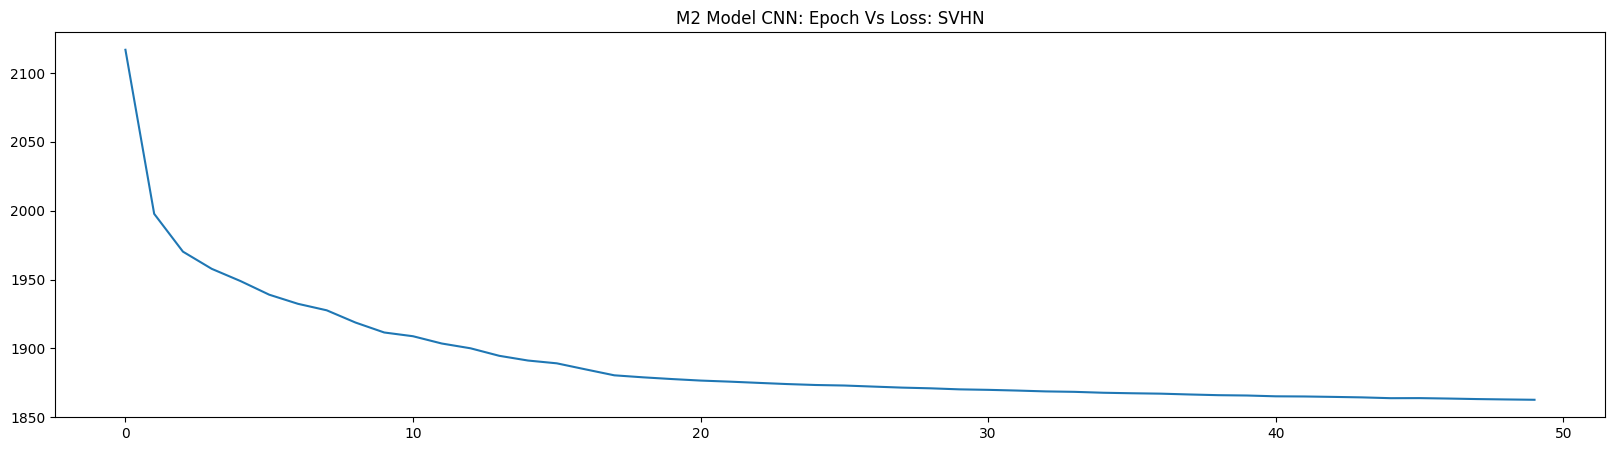

In [54]:
plt.rcParams["figure.figsize"] = [20, 5]

plt.plot(data[:,0], data[:,3])
plt.title("M2 Model CNN: Epoch Vs Loss: SVHN") 

# # Please pardon M3 typo here

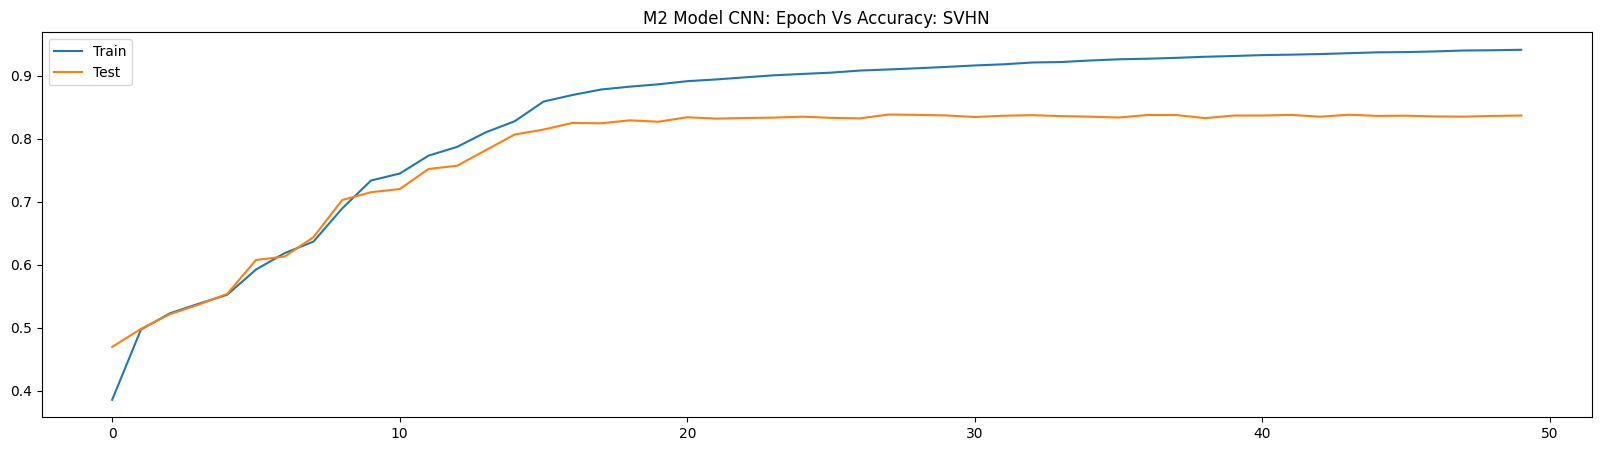

In [55]:
plt.rcParams["figure.figsize"] = [20, 5]

plt.plot(data[:,0], data[:,1])
plt.plot(data[:,0], data[:,2])
plt.title("M2 Model CNN: Epoch Vs Accuracy: SVHN")
plt.legend(('Train', 'Test'))

# Please pardon M3 typo here

In [56]:
# model.load_state_dict(torch.load('M2_supervised_SVHN_CNN_LATEST_alpha_point_1', map_location=torch.device('cpu')),)

In [57]:
model.eval()

correct_prediction = 0
total_labels = 0
with torch.no_grad():
    for batch_idx, (x, labels) in enumerate(tqdm(test_loader)):
        # x = x.view(x.size(0), x_dim)
        x = x.to(DEVICE)
        labels = labels.to(DEVICE)
        x_hat, mean, log_var, y_hat = model(x)
        
        correct_prediction += (torch.max(y_hat,1).indices == labels).sum().item() 
        total_labels += len(labels)
        
correct_prediction/total_labels

100%|██████████| 261/261 [00:09<00:00, 27.97it/s]


0.8368546404425322

<Figure size 600x500 with 0 Axes>

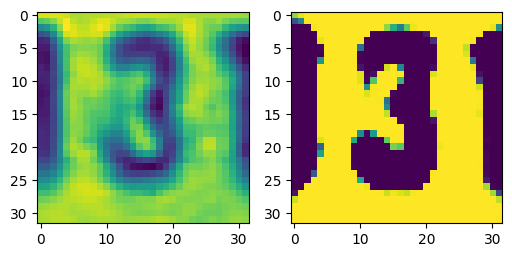

<Figure size 600x500 with 0 Axes>

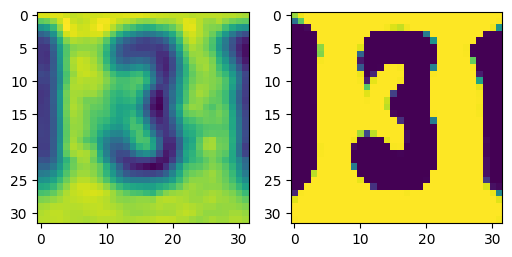

<Figure size 600x500 with 0 Axes>

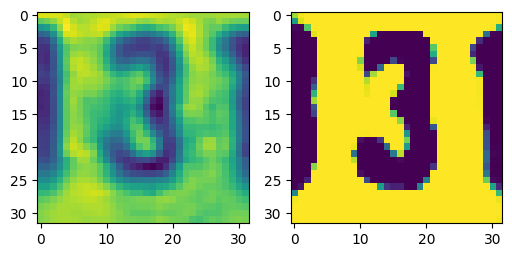

<Figure size 600x500 with 0 Axes>

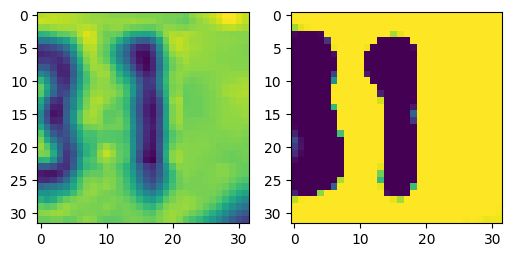

<Figure size 600x500 with 0 Axes>

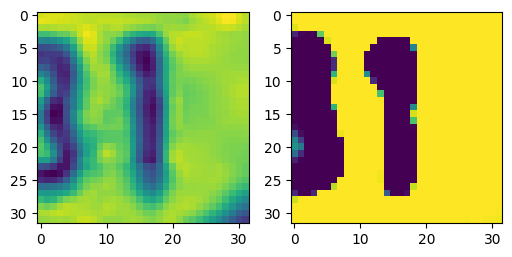

In [103]:
# Plotting only one channel here because of unnormalizatio is not done 

plt.rcParams["figure.figsize"] = [6, 5]

def show_image(x, x_hat, idx, xdim):
    x = x.view(-1, xdim, xdim)
    x_hat = x_hat.view(-1, xdim, xdim)
    
    fig = plt.figure()
    fig, ax = plt.subplots(nrows=1, ncols=2)
    
    # ax[0].imshow(x[idx].permute(1, 2, 0).cpu().numpy())
    # ax[1].imshow(x_hat[idx].permute(1, 2, 0).cpu().numpy())

    ax[0].imshow(x[idx].cpu().numpy())
    ax[1].imshow(x_hat[idx].cpu().numpy())

    plt.show()
    
# Plot 5 images.
for i in range(5):
    show_image(x, x_hat, idx=i, xdim=32)